In [2]:
!pip install keras_core
!pip install keras_nlp

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras_core as keras
import keras_nlp
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 49.0 MB/s eta 0:00:00
Using TensorFlow backend
TensorFlow version: 2.13.0
KerasNLP version: 0.6.2


In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
BATCH_SIZE = 32
EPOCHS = 2
NUM_FOLDS = 2  # Number of cross-validation folds

In [5]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [6]:
# Create a TF-IDF vectorizer for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
f1_scores = []
confusion_matrices = []

for fold, (train_index, val_index) in enumerate(skf.split(df_train["text"], df_train["target"]), 1):
    print(f"Fold {fold}/{NUM_FOLDS}")

    # Split the data into training and validation sets
    X_train, X_val = df_train["text"].iloc[train_index], df_train["text"].iloc[val_index]
    y_train, y_val = df_train["target"].iloc[train_index], df_train["target"].iloc[val_index]

    # Preprocess text data using TF-IDF
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

    # Fit the XGBoost model
    dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
    dval = xgb.DMatrix(X_val_tfidf, label=y_val)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    num_round = 1000  # Adjust the number of boosting rounds as needed
    xgb_model = xgb.train(xgb_params, dtrain, num_round, evals=watchlist, early_stopping_rounds=10, verbose_eval=True)

    # Predict on the validation set
    y_pred_val_prob = xgb_model.predict(dval)
    y_pred_val = (y_pred_val_prob > 0.5).astype(int)

    # Calculate F1 score and confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    print(f"Fold {fold} - F1 Score: {f1_score:.2f}")

    f1_scores.append(f1_score)
    confusion_matrices.append(confusion_matrix(y_val, y_pred_val))

Fold 1/2
[0]	train-logloss:0.67468	eval-logloss:0.67691
[1]	train-logloss:0.65939	eval-logloss:0.66421
[2]	train-logloss:0.64527	eval-logloss:0.65230
[3]	train-logloss:0.63370	eval-logloss:0.64309
[4]	train-logloss:0.62250	eval-logloss:0.63498
[5]	train-logloss:0.61276	eval-logloss:0.62776
[6]	train-logloss:0.60515	eval-logloss:0.62219
[7]	train-logloss:0.59831	eval-logloss:0.61705
[8]	train-logloss:0.59154	eval-logloss:0.61240
[9]	train-logloss:0.58516	eval-logloss:0.60835
[10]	train-logloss:0.57935	eval-logloss:0.60411
[11]	train-logloss:0.57385	eval-logloss:0.60106
[12]	train-logloss:0.56903	eval-logloss:0.59784
[13]	train-logloss:0.56460	eval-logloss:0.59427
[14]	train-logloss:0.55974	eval-logloss:0.59094
[15]	train-logloss:0.55520	eval-logloss:0.58757
[16]	train-logloss:0.55195	eval-logloss:0.58517
[17]	train-logloss:0.54768	eval-logloss:0.58271
[18]	train-logloss:0.54413	eval-logloss:0.58112
[19]	train-logloss:0.54143	eval-logloss:0.57914
[20]	train-logloss:0.53834	eval-logloss:0

In [7]:
# Calculate and display the mean F1 score and mean confusion matrix
mean_f1_score = np.mean(f1_scores)
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

print("Mean F1 Score:", mean_f1_score)
print("Mean Confusion Matrix:")
print(mean_confusion_matrix)

Mean F1 Score: 0.709096523877933
Mean Confusion Matrix:
[[1889.5  281.5]
 [ 582.5 1053. ]]


In [34]:
your_sentence = "Tsunamis are comming"
sentence = tfidf_vectorizer.transform([your_sentence])
dtest = xgb.DMatrix(sentence)
prediction = xgb_model.predict(dtest)
predicted_label = int(prediction[0] > 0.5)

if predicted_label == 0:
    print("The sentence is not disastrous.")
else:
    print("The sentence is disastrous.")

The sentence is not disastrous.


In [14]:
# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
# Initialize lists to store evaluation metrics
f1_scores = []
confusion_matrices = []

Fold 1/2
265570304/265570304 [==============================] - 13s 0us/step
Epoch 1/2
119/119 [==============================] - 107s 663ms/step - loss: 0.5665 - accuracy: 0.7254 - val_loss: 0.4281 - val_accuracy: 0.8161
Epoch 2/2
119/119 [==============================] - 24s 187ms/step
Fold 1 - F1 Score: 0.80
Fold 2/2
Epoch 1/2
119/119 [==============================] - 104s 694ms/step - loss: 0.5644 - accuracy: 0.7129 - val_loss: 0.4263 - val_accuracy: 0.8226
Epoch 2/2
119/119 [==============================] - 24s 187ms/step
Fold 2 - F1 Score: 0.80


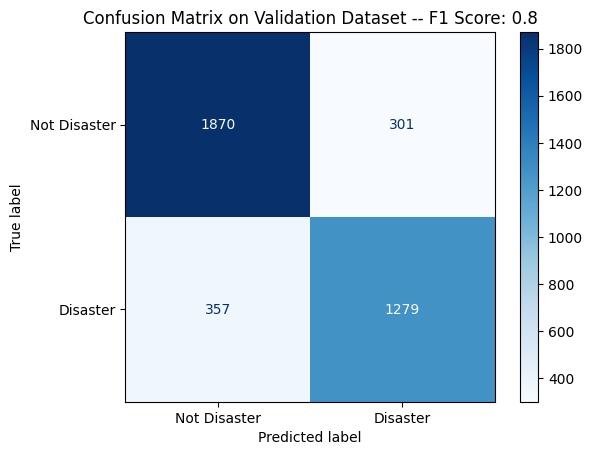

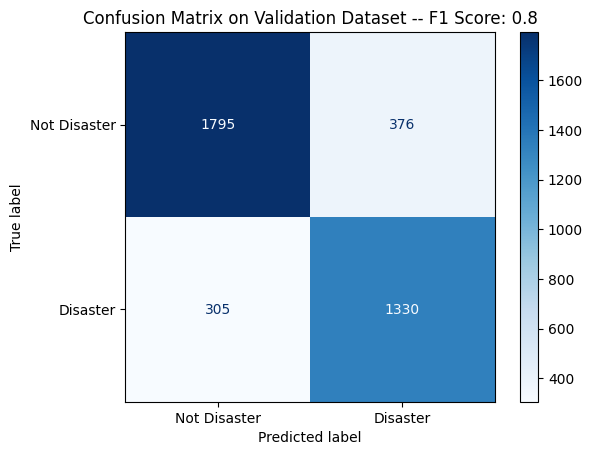

In [15]:
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(df_train["text"], df_train["target"]), 1):
    print(f"Fold {fold}/{NUM_FOLDS}")

    # Split the data into training and validation sets
    X_train, X_val = df_train["text"].iloc[train_index], df_train["text"].iloc[val_index]
    y_train, y_val = df_train["target"].iloc[train_index], df_train["target"].iloc[val_index]

    # Load a DistilBERT model.
    preset = "distil_bert_base_en_uncased"
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
        preset,
        sequence_length=160,
        name="preprocessor_4_tweets"
    )

    # Pretrained classifier.
    classifier = keras_nlp.models.DistilBertClassifier.from_preset(
        preset,
        preprocessor=preprocessor,
        num_classes=2
    )

    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=1e-5),
        metrics=["accuracy"]
    )

    # Fit the model
    history = classifier.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val)
    )


    def displayConfusionMatrix(y_true, y_pred, dataset):
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster", "Disaster"],
            cmap=plt.cm.Blues
        )

        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
        f1_score = tp / (tp + ((fn + fp) / 2))

        disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

    y_pred_val = classifier.predict(X_val)

    displayConfusionMatrix(y_val, y_pred_val, "Validation")

    # Calculate F1 score and confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    print(f"Fold {fold} - F1 Score: {f1_score:.2f}")

    f1_scores.append(f1_score)
    confusion_matrices.append(confusion_matrix(y_val, np.argmax(y_pred_val, axis=1)))

In [17]:
# Calculate and display the mean F1 score and mean confusion matrix
mean_f1_score = np.mean(f1_scores)
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

print("Mean F1 Score:", mean_f1_score)
print("Mean Confusion Matrix:")
print(mean_confusion_matrix)

Mean F1 Score: 0.7957834108416314
Mean Confusion Matrix:
[[1832.5  338.5]
 [ 331.  1304.5]]


In [37]:
def predict_sentence(sentence, model, preprocessor):
    predictions = model.predict(sentence)
    return predictions
print('Enter you tweet : ')
your_sentence = input()
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,sequence_length=160,name="preprocessor_4_tweets")
predictions = predict_sentence([your_sentence], classifier, preprocessor)
predicted_label = np.argmax(predictions, axis=1).item()
if predicted_label == 0:
    print("The sentence is not disastrous.")
else:
    print("The sentence is disastrous.")

Enter you tweet : 
fire was huge
1/1 [==============================] - 1s 1s/step
The sentence is disastrous.
